In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use("seaborn-colorblind")

/tmp/ipykernel_47/2323518964.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


In [2]:
!python -m pip install git+https://github.com/leifdenby/nb_black/#egg=nb_black

  Cloning https://github.com/leifdenby/nb_black/ to /tmp/pip-install-whf17fij/nb-black_58d63846cbed41de836dcc3fffcbf8f5
  Running command git clone --filter=blob:none --quiet https://github.com/leifdenby/nb_black/ /tmp/pip-install-whf17fij/nb-black_58d63846cbed41de836dcc3fffcbf8f5
  Resolved https://github.com/leifdenby/nb_black/ to commit ae8d0b42eba30d2235aa0a598a2f5f460e0e5b99
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for black>=19.3 from https://files.pythonhosted.org/packages/75/1a/d0cfb2ae52ebfe7eeeb4b23090bff5ad9e071015c0373da9790f0e4a790b/black-23.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 3.5 MB/s eta 0:00:00
  Obtaining dependency information for packaging>=22.0 from https://files.pythonhosted.org/packages/ec/1a/610693ac4ee14fcdf2d9bf3c493370e4f2ef7ae2e19217d7a237ff42367d/packaging-23.2-py3-none-any.whl.metadata
  Obtaining dependency information for path

In [3]:
%load_ext lab_black

## EDA

## What signs are we trying to predict?
 - 250 unique signs
 - Ranging from 299-415 examples of each

In [4]:
BASE_DIR = "../input/asl-signs/"
train = pd.read_csv(f"{BASE_DIR}/train.csv")
train.shape

(94477, 4)

In [5]:
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


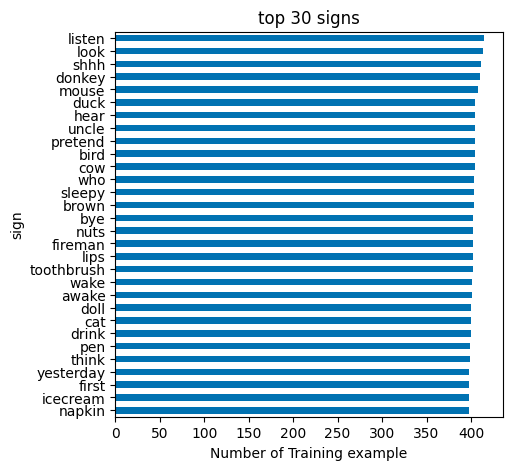

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
train["sign"].value_counts().head(30).sort_values(ascending=True).plot(
    kind="barh", figsize=(5, 5), title="top 30 signs"
)
ax.set_xlabel("Number of Training example")
plt.show()

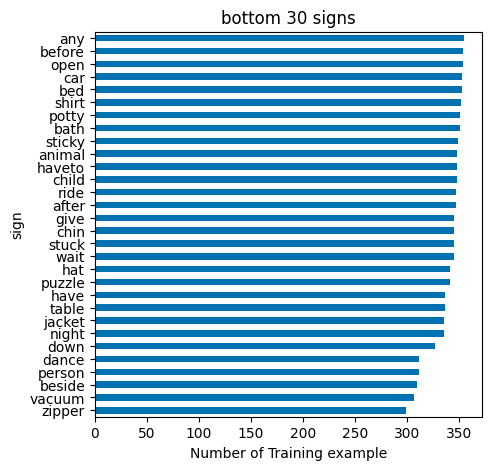

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
train["sign"].value_counts().tail(30).sort_values(ascending=True).plot(
    kind="barh", figsize=(5, 5), title="bottom 30 signs"
)
ax.set_xlabel("Number of Training example")
plt.show()

## Parquet Landmark Data

#### Each parquet fil is in the path:
    - train_landmark_files/[participant_id]/[sequence_id].parquet
    - The parquet's associated sign can be fount in train.csv

#### As listen is top sign in the data, we check how much it is present in path

In [8]:
train.query('sign=="listen"')["path"].value_counts()

path
train_landmark_files/37055/1011397240.parquet    1
train_landmark_files/2044/3547238688.parquet     1
train_landmark_files/53618/36372513.parquet      1
train_landmark_files/25571/3634125751.parquet    1
train_landmark_files/26734/3631518275.parquet    1
                                                ..
train_landmark_files/62590/2173500274.parquet    1
train_landmark_files/2044/2159292151.parquet     1
train_landmark_files/32319/2158194080.parquet    1
train_landmark_files/49445/2156693852.parquet    1
train_landmark_files/37779/993771589.parquet     1
Name: count, Length: 415, dtype: int64

In [9]:
example = train.query('sign == "listen"')["path"].values

In [10]:
for i, f in enumerate(example):
    example_landmark = pd.read_parquet(f"{BASE_DIR}/{f}")
    unique_frame = example_landmark["frame"].nunique()
    unique_types = example_landmark["type"].nunique()
    types_in_video = example_landmark["type"].unique()
    print(f"the file has {unique_frame} unique frames")
    print(f"the file has {unique_types} unique types")
    print(f"the file has {types_in_video} types in video")
    if i == 20:
        break

the file has 6 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] types in video
the file has 23 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] types in video
the file has 28 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] types in video
the file has 68 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] types in video
the file has 6 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] types in video
the file has 16 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] types in video
the file has 6 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] types in video
the file has 6 unique frames
the file has 4 unique types
the file has ['face' 'left_hand' 'pose' 'right_hand'] typ

## Create Metadata for Training Dataset

In [11]:
N_parquets_to_read = 1000
combined_meta = {}
for i, d in tqdm(train.iterrows(), total=len(train)):
    file_path = d["path"]
    example_landmark = pd.read_parquet(f"{BASE_DIR}/{file_path}")
    ## get number of landmarks with x, y , z location data per type
    meta = (
        example_landmark.dropna(subset=["x", "y", "z"])["type"].value_counts().to_dict()
    )
    meta["frames"] = example_landmark["frame"].nunique()
    xyz_meta = (
        example_landmark.agg(
            {
                "x": ["min", "max", "mean"],
                "y": ["min", "max", "mean"],
                "z": ["min", "max", "mean"],
            }
        )
        .unstack()
        .to_dict()
    )
    for key in xyz_meta.keys():
        new_key = key[0] + "-" + key[1]
        meta[new_key] = xyz_meta[key]
    combined_meta[file_path] = meta
    if i >= N_parquets_to_read:
        break

  0%|          | 0/94477 [00:00<?, ?it/s]

In [12]:
train_with_meta = train.merge(
    pd.DataFrame(combined_meta).T.reset_index().rename(columns={"index": "path"}),
    how="left",
)

#### What are the most frequent types of landmarks provided?
- face has a lot more datapoints because mediapipe provides 468 3D data points per frame.

<Axes: title={'center': 'sum of rows by landmark type'}>

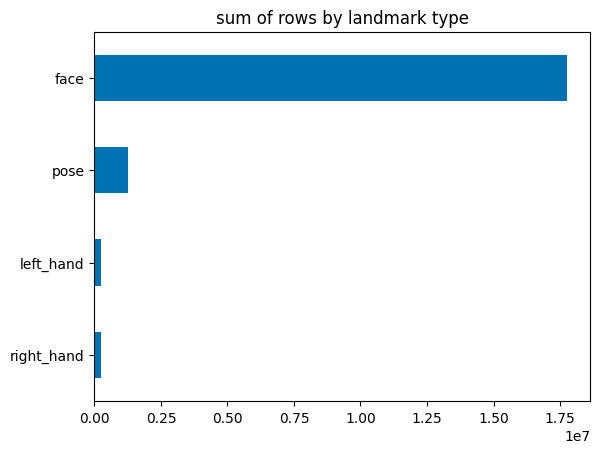

In [13]:
train_with_meta[["face", "pose", "left_hand", "right_hand"]].sum().sort_values().plot(
    kind="barh", title="sum of rows by landmark type"
)

#### Data Cleaning - Every parquet file has at least some datapoints for all four types of landmarks: - face, pose, left hand and right hand.

<Axes: title={'center': 'Rate of Frame/keypoints with data'}>

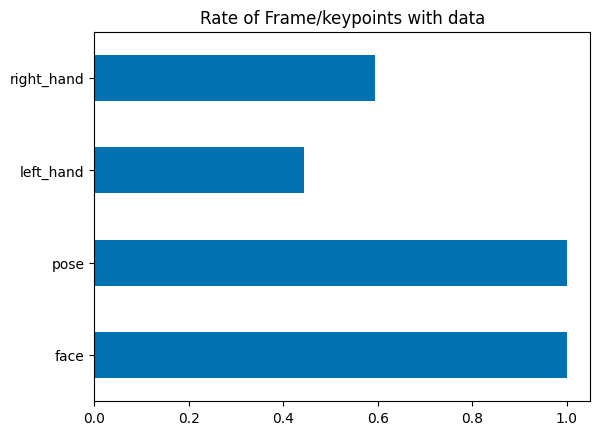

In [14]:
### checking to see if the number of landmark is type zero
(
    train_with_meta.query("index<1000").fillna(0)[
        ["face", "pose", "left_hand", "right_hand"]
    ]
    > 0
).mean().plot(kind="barh", title="Rate of Frame/keypoints with data")

## example

In [15]:
example_fn = train_with_meta.dropna().query('sign=="shhh"')["path"].values[0]
example_landmark = pd.read_parquet(f"{BASE_DIR}/{example_fn}")

In [16]:
example_landmark["frame"].median()

25.0

In [17]:
example_landmark.query("frame == 25")["type"].value_counts()

type
face          468
pose           33
left_hand      21
right_hand     21
Name: count, dtype: int64

## 3D plot of landmarks from example

In [18]:
import plotly.express as px

example_frame = example_landmark.query("frame == 17")
px.scatter_3d(example_frame, x="x", y="y", z="z", color="type")

## Evaluation

In [ ]:
def load_relevant_data_subset(pq_path):
    data_columns = ["x", "y", "z"]
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)